# Phase 4: ML-Driven Regime-Aware Risk Engine  

### Motivation  
Earlier phases highlighted a fundamental trade-off in model design:  
- **Dynamic models (e.g., GJR-GARCH):** Responsive to market stress and volatility clustering, but struggled with unconditional accuracy (failing Kupiec’s test).  
- **Static models (e.g., EVT):** Strong on unconditional accuracy and tail coverage, but failed to adapt dynamically to changing regimes (failing Christoffersen’s test).  

### Objective  
The goal of **Phase 4** is to overcome this trade-off by designing a **hybrid, regime-aware risk engine**. This model uses machine learning to blend GJR-GARCH and EVT depending on the prevailing market regime. By doing so, it aims to:  

- Capture both **responsiveness** and **accuracy**.  
- Pass **Kupiec (POF)** and **Christoffersen (Independence)** backtests simultaneously.  
- Maintain **Basel III Green Zone** compliance for capital efficiency.  


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# --- 1. Setup and Feature Engineering ---
DATA_DIR = "data"
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']

# --- FEATURE ENGINEERING: Create a richer feature set ---
# We'll use returns and 1-month rolling volatility as features
features = pd.DataFrame(index=portfolio_returns.index)
features['returns'] = portfolio_returns
features['volatility'] = portfolio_returns.rolling(22).std()
features.dropna(inplace=True)

# Reshape data for HMM
hmm_features = features.values



---

## HMM for Regime Detection  

### Objective  
Use a Hidden Markov Model (HMM) to identify distinct market regimes, providing a data-driven signal to control blending in the hybrid model.  

### Methodology  
- **Features:** Daily log returns + 22-day rolling volatility.  
- **Model Selection:** Chose 4 states using BIC.  
- **Specification:** GaussianHMM with 4 components, trained on full history.  


Finding the optimal number of regimes using BIC...


c:\Users\siddh\miniconda3\envs\pyt\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\Users\siddh\miniconda3\envs\pyt\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\Users\siddh\miniconda3\envs\pyt\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
Model is not converging.  Current: 35974.256630010525 is not greater than 35974.349760303776. Delta is 

Optimal number of regimes found: 4


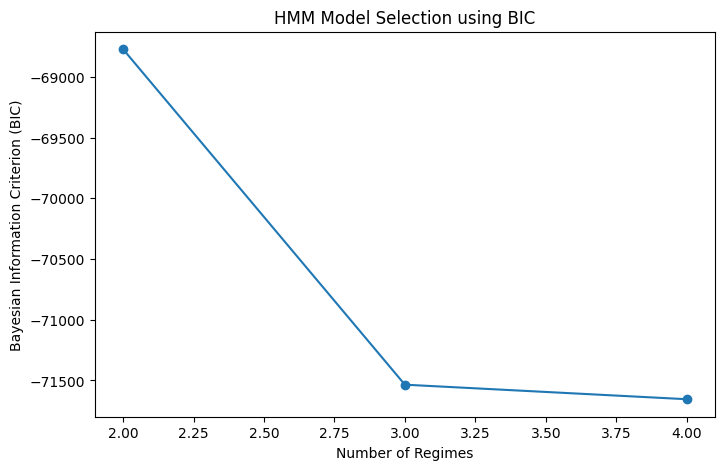

c:\Users\siddh\miniconda3\envs\pyt\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
Model is not converging.  Current: 35974.256630009884 is not greater than 35974.34976030124. Delta is -0.09313029135228135



✅ Final HMM model fitting complete.

High-volatility regime identified as state: 3

--- Regime 0 ---
Mean Return: -0.00002
Mean Volatility: 0.01158

--- Regime 1 ---
Mean Return: -0.00063
Mean Volatility: 0.02005

--- Regime 2 ---
Mean Return: 0.00084
Mean Volatility: 0.00594

--- Regime 3 ---
Mean Return: -0.00341
Mean Volatility: 0.03684


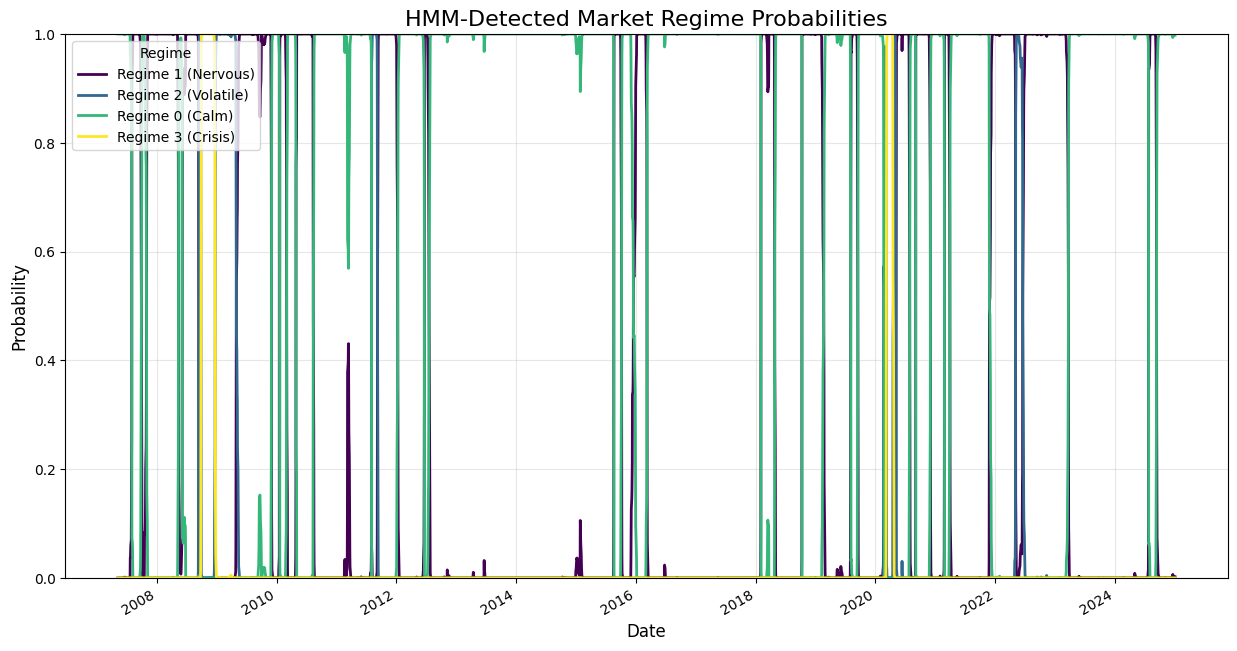

In [10]:
# --- 2. Model Selection using BIC ---
# We will test HMMs with 2, 3, and 4 states (regimes)
possible_states = range(2, 5)
bic_scores = []

print("\nFinding the optimal number of regimes using BIC...")
for n_states in possible_states:
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(hmm_features)
    bic_scores.append(model.bic(hmm_features))

# Select the model with the lowest BIC score
optimal_states = possible_states[np.argmin(bic_scores)]
print(f"Optimal number of regimes found: {optimal_states}")

# Plot the BIC scores
plt.figure(figsize=(8, 5))
plt.plot(possible_states, bic_scores, 'o-')
plt.title('HMM Model Selection using BIC')
plt.xlabel('Number of Regimes')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.show()


# --- 3. Fit the Final, Optimal HMM Model ---
final_hmm_model = GaussianHMM(n_components=optimal_states, covariance_type="full", n_iter=1000, random_state=42)
final_hmm_model.fit(hmm_features)
print("\n✅ Final HMM model fitting complete.")

# --- 4. Identify and Analyze the Regimes ---
# Identify the high-volatility regime by finding the state with the highest volatility component
volatilities = [np.sqrt(cov[1, 1]) for cov in final_hmm_model.covars_]
high_vol_regime = np.argmax(volatilities)
print(f"\nHigh-volatility regime identified as state: {high_vol_regime}")

for i in range(optimal_states):
    print(f"\n--- Regime {i} ---")
    print(f"Mean Return: {final_hmm_model.means_[i][0]:.5f}")
    print(f"Mean Volatility: {final_hmm_model.means_[i][1]:.5f}")

# --- 5. Visualize All Regime Probabilities ---

# We assume 'final_hmm_model' and 'hmm_features' are in memory.

# Get the probabilities for all regimes
all_regime_probabilities = final_hmm_model.predict_proba(hmm_features)

# Create a DataFrame for easier plotting
prob_df = pd.DataFrame(all_regime_probabilities, index=features.index)

# Identify and label the regimes based on their volatility
volatilities = [np.sqrt(cov[1, 1]) for cov in final_hmm_model.covars_]
# Sort the regimes from lowest volatility to highest
regime_order = np.argsort(volatilities)
# Create descriptive labels
regime_labels = {
    regime_order[0]: 'Regime 0 (Calm)',
    regime_order[1]: 'Regime 1 (Nervous)',
    regime_order[2]: 'Regime 2 (Volatile)',
    regime_order[3]: 'Regime 3 (Crisis)'
}
prob_df.rename(columns=regime_labels, inplace=True)


# --- Create the Plot ---
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the probability of each regime
prob_df.plot(ax=ax, linewidth=2, colormap='viridis')

ax.set_title('HMM-Detected Market Regime Probabilities', fontsize=16)
ax.set_ylabel('Probability', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(title='Regime', loc='upper left')
ax.grid(True, alpha=0.3)

plt.show()

### Key Findings  
- **Regimes Identified:**  
  - Calm: Low vol, positive returns.  
  - Nervous: Mid-low vol, flat returns.  
  - Volatile: High vol, mild losses.  
  - Crisis: Extreme vol, large losses.  
- **High Confidence:** Clear, near-100% regime assignments. Correctly captured 2008 and 2020 crashes as “Crisis.”  

### Risk Implications  
- **Objective Signal:** Provides a robust, unsupervised classification of market states.  
- **Blending Control:** Enables regime-specific weighting of GJR-GARCH and EVT, forming the backbone of the final hybrid model.  
---

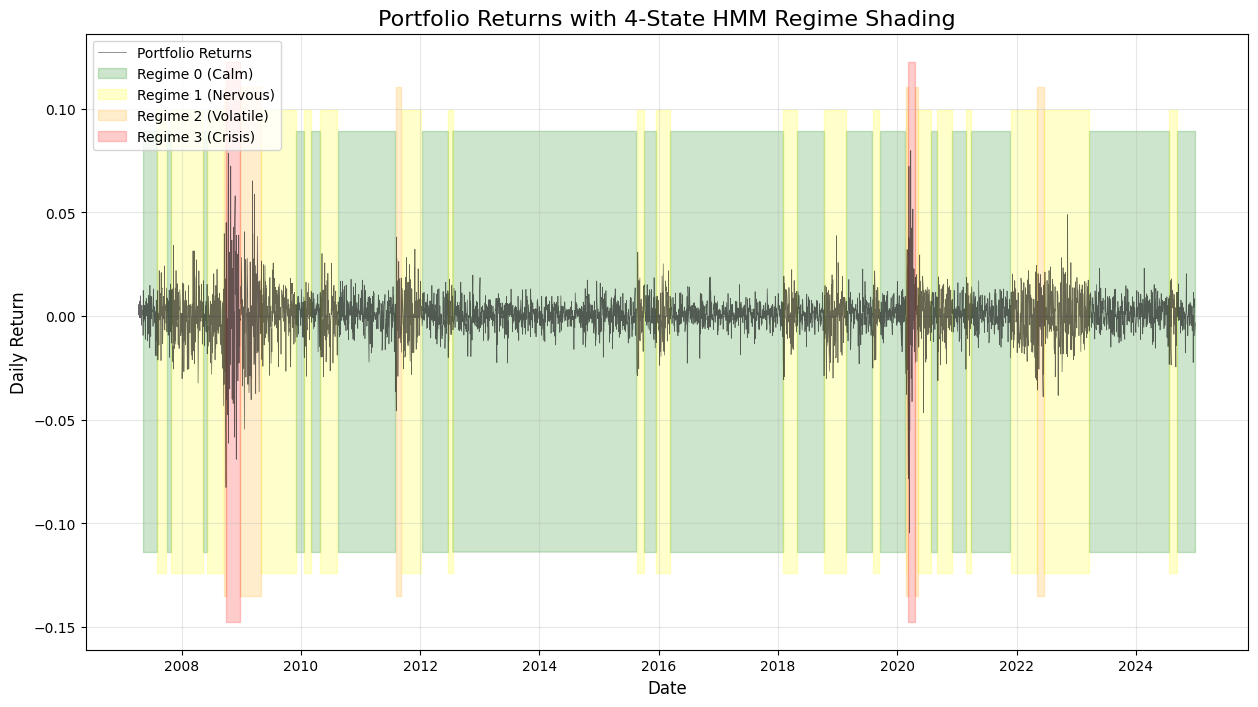

In [11]:
# --- 1. Determine the Most Likely Regime for Each Day ---
# We use idxmax() to find the column name with the highest probability for each row
most_likely_regime = prob_df.idxmax(axis=1)

# --- 2. Create the Plot ---
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the portfolio returns
ax.plot(portfolio_returns, color='black', alpha=0.6, linewidth=0.5, label='Portfolio Returns')

# --- 3. Add Shading for Each Regime ---
# Define a color map for the regimes
color_map = {
    'Regime 0 (Calm)': 'green',
    'Regime 1 (Nervous)': 'yellow',
    'Regime 2 (Volatile)': 'orange',
    'Regime 3 (Crisis)': 'red'
}

# Use fill_between to shade the background for each regime
for regime_name, color in color_map.items():
    ax.fill_between(
        most_likely_regime.index,
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        where=(most_likely_regime == regime_name),
        color=color,
        alpha=0.2,
        label=regime_name
    )

ax.set_title('Portfolio Returns with 4-State HMM Regime Shading', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.show()

## HMM Regime Visualization

**Objective:**  
Map the 4-state HMM output onto portfolio returns, creating a "market weather map" of market regimes.

**Methodology:**  
- Each day assigned to regime with highest posterior probability (`idxmax`).  
- Color-coded shading: Calm (Green), Nervous (Yellow), Volatile (Orange), Crisis (Red).  

**Findings:**  
- Clear transitions between regimes; calm phases punctuated by nervous/volatile states.  
- Crisis (Red) only at major dislocations (2008 GFC, 2020 COVID crash).  
- Alignment with known market cycles validates model classification.  

**Implications:**  
- Dashboard-ready, at-a-glance regime detection.  
- Intuitive communication of complex HMM outputs.  

**Analogy (Market Weather Map):**  
- Green = Calm (sunny), Yellow = Nervous (cloudy),  
- Orange = Volatile (storm), Red = Crisis (hurricane).  

**Technical Note:**  
Uses Maximum A Posteriori (MAP) rule:  
\[
\hat{S}_t = \arg\max_j P(S_t=j \mid O_{1:T})
\]  
`idxmax` assigns states; `fill_between` shades regions → yields most likely regime path.


---

✅ HMM parameters extracted.
Calmest Regime Volatility: 0.0059
Crisis Regime Volatility: 0.0368

✅ Daily stress factor calculated.
Preview of the stress factor:
Date
2007-05-11    0.000000e+00
2007-05-14    9.647933e-07
2007-05-15    9.895289e-07
2007-05-16    8.836307e-07
2007-05-17    9.529268e-07
Name: StressFactor, dtype: float64


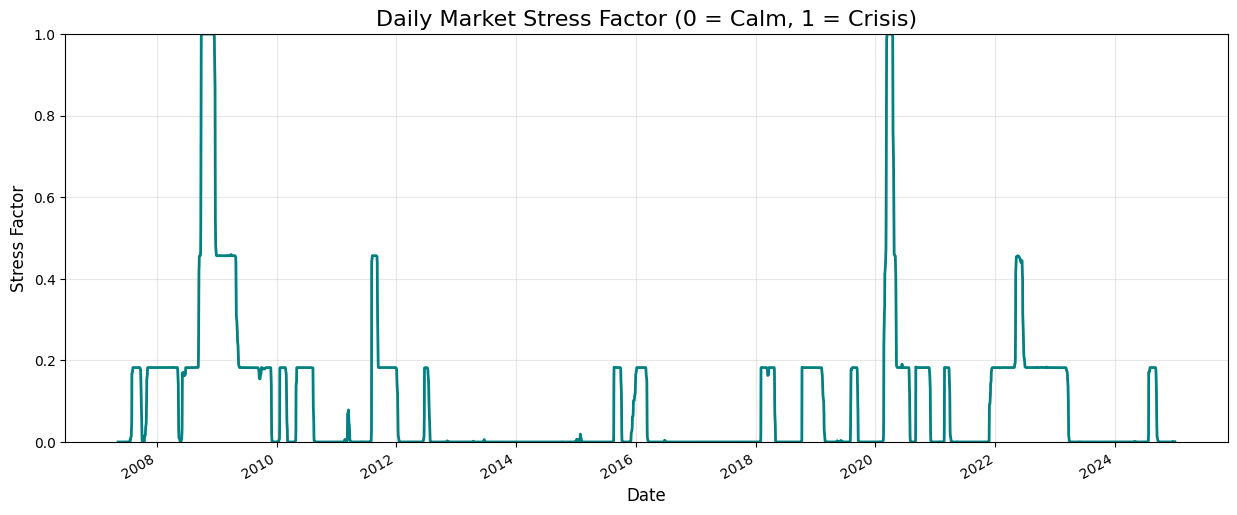

In [20]:
# --- 1. Extract HMM Parameters ---
# We assume 'final_hmm_model' is in memory from the previous HMM fit.

# Get the mean volatility for each of the 4 regimes
# Note: Volatility is the second feature (index 1) in our HMM
regime_vols = final_hmm_model.means_[:, 1]

# Get the DataFrame of regime probabilities
# We assume 'prob_df' from the previous visualization is in memory
# If not, you can recreate it:
# all_regime_probabilities = final_hmm_model.predict_proba(hmm_features)
# prob_df = pd.DataFrame(all_regime_probabilities, index=features.index)

# Find the volatility of the calmest and most volatile states
v_calm = regime_vols.min()
v_crisis = regime_vols.max()

print("✅ HMM parameters extracted.")
print(f"Calmest Regime Volatility: {v_calm:.4f}")
print(f"Crisis Regime Volatility: {v_crisis:.4f}")

# --- 2. Calculate the Weighted Volatility ---
# This is the expected volatility for each day, given the regime probabilities
weighted_vol = prob_df.dot(regime_vols)

# --- 3. Normalize to Create the Stress Factor ---
# This scales the weighted volatility to be between 0 (fully calm) and 1 (fully crisis)
stress_factor = (weighted_vol - v_calm) / (v_crisis - v_calm)
stress_factor.name = "StressFactor"

print("\n✅ Daily stress factor calculated.")
print("Preview of the stress factor:")
print(stress_factor.head())

# --- 4. Plot the Stress Factor ---
fig, ax = plt.subplots(figsize=(15, 6))
stress_factor.plot(ax=ax, color='teal', linewidth=2)
ax.set_title('Daily Market Stress Factor (0 = Calm, 1 = Crisis)', fontsize=16)
ax.set_ylabel('Stress Factor', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.show()

---

In [ ]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- 1. Define Constants and Load Core Data ---
DATA_DIR = "data"
WINDOW = 252
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"),
    index_col='Date',
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']


In [ ]:
# --- Generate the GJR-GARCH VaR Series ---
def fit_gjr_garch_model(returns_window):
    try:
        model = arch_model(
            returns_window * 100, vol='Garch', p=1, o=1, q=1,
            mean='Constant', dist='t'
        )
        fit = model.fit(disp='off')
        if not fit.convergence_flag: return fit, True
        else: return None, False
    except Exception: return None, False

gjr_results = []
gjr_dates = []
for i in tqdm(range(WINDOW, len(portfolio_returns)), desc="Calculating Rolling GJR-GARCH VaR"):
    window = portfolio_returns.iloc[i-WINDOW:i]
    current_date = portfolio_returns.index[i]
    gjr_garch_fit, success = fit_gjr_garch_model(window)
    if success:
        forecast = gjr_garch_fit.forecast(horizon=1)
        cond_mean = forecast.mean.iloc[-1, 0] / 100
        cond_vol = np.sqrt(forecast.variance.iloc[-1, 0]) / 100
        std_resid = gjr_garch_fit.resid / gjr_garch_fit.conditional_volatility
        q = std_resid.quantile(0.01)
        var_99 = cond_mean + cond_vol * q
    else:
        var_99 = window.quantile(0.01) # Fallback
    gjr_results.append(var_99)
    gjr_dates.append(current_date)

gjr_garch_var_99 = pd.Series(gjr_results, index=gjr_dates, name='GJR_GARCH_VaR_99')
print("\n✅ Step 1 complete: Rolling GJR-GARCH VaR series created.")

Calculating Rolling GJR-GARCH VaR: 100%|██████████| 4210/4210 [01:11<00:00, 59.18it/s]


✅ Step 1 complete: Rolling GJR-GARCH VaR series created.


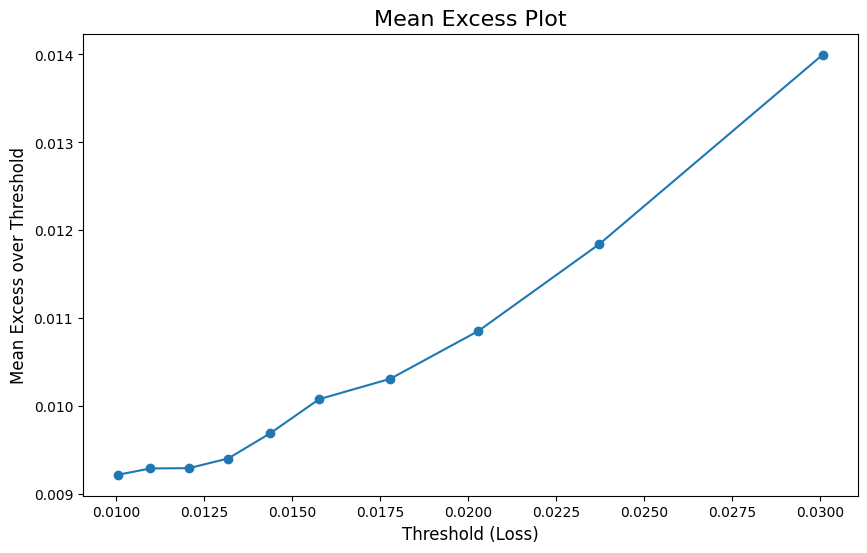


--- EVT-GPD Model Fit (at 1.58% threshold) ---
Estimated Shape parameter (xi): 0.1571
Estimated Scale parameter (beta): 0.0085

99% VaR Estimate (EVT): -3.1353%
97.5% ES Estimate (EVT): -3.3256%


In [ ]:
from scipy.stats import genpareto

# --- 1. Setup for EVT ---
# We will apply EVT to the historical portfolio returns
# portfolio_returns should be in memory

# We analyze losses, so we'll use the negative of the returns
losses = -portfolio_returns.dropna()

# --- 2. Justify Threshold with a Mean Excess Plot ---
# A Mean Excess Plot helps identify a suitable threshold for the GPD.
# We look for a region where the plot is roughly linear.
from statsmodels.graphics.gofplots import qqplot

# For simplicity in visualization, we can use a practical approach
# by plotting mean excess over a range of thresholds.
thresholds = losses.quantile(np.linspace(0.90, 0.99, 10))
mean_excess = [losses[losses > t].mean() - t for t in thresholds]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, mean_excess, 'o-')
ax.set_title('Mean Excess Plot', fontsize=16)
ax.set_xlabel('Threshold (Loss)', fontsize=12)
ax.set_ylabel('Mean Excess over Threshold', fontsize=12)
plt.show()

# --- 3. Fit the Generalized Pareto Distribution (GPD) ---
# Based on the plot, we'll select a threshold. Let's start with the 95th percentile.
threshold = losses.quantile(0.95)
exceedances = losses[losses > threshold] - threshold

# Fit the GPD to the exceedances
shape, loc, scale = genpareto.fit(exceedances, floc=0) # floc=0 sets the location parameter to 0

print(f"\n--- EVT-GPD Model Fit (at {threshold*100:.2f}% threshold) ---")
print(f"Estimated Shape parameter (xi): {shape:.4f}")
print(f"Estimated Scale parameter (beta): {scale:.4f}")

# (Keep all your setup and GPD fitting code the same)
# ...

# --- 4. Calculate VaR and ES using the fitted GPD (Definitive Correction) ---
n = len(losses)
n_u = len(exceedances)
phi_u = n_u / n
# Define alphas for both VaR and ES
alpha_var = 0.01   # For 99% VaR
alpha_es = 0.025  # For 97.5% ES

# --- THE FIX: Use the standard, correct formulas ---

# VaR calculation for 99%
evt_var_99 = threshold + (scale / shape) * ( (n / n_u * (1 - (1-alpha_var)))**(-shape) - 1)

# ES calculation for 97.5%
# First, calculate the 97.5% VaR threshold needed for the ES formula
var_975_for_es = threshold + (scale / shape) * ( (n / n_u * (1 - (1-alpha_es)))**(-shape) - 1)
# Then, use the standard formula for GPD ES
evt_es_975 = (var_975_for_es + scale - shape * threshold) / (1 - shape)

# Convert both to negative numbers to represent losses
evt_var_99 = -evt_var_99
evt_es_975 = -evt_es_975


print(f"\n99% VaR Estimate (EVT): {evt_var_99*100:.4f}%")
print(f"97.5% ES Estimate (EVT): {evt_es_975*100:.4f}%")

---

## Phase 4: Hybrid Model Component Preparation

**Objective:**  
Build the two core VaR components (dynamic + static) that the HMM will blend into the final hybrid model.

### 1. Dynamic Component – Rolling GJR-GARCH VaR
- **Method:** GJR-GARCH(1,1) with Student-t, 252-day rolling window.  
- Combined conditional volatility forecast with empirical quantile of standardized residuals (Filtered Historical Simulation).  
- **Result:** Full time series of 99% VaR (`gjr_garch_var_99`), representing the *stressed-state* (high gear).  

### 2. Static Component – Unconditional EVT VaR
- **Method:** EVT (POT approach) with 95th percentile threshold; GPD fitted to exceedances.  
- **Key Finding:** Positive shape parameter (ξ=0.1571) → heavy-tailed returns.  
- **Result:** Static 99% VaR = **-3.14%**, serving as the *calm-state* (low gear).  

**Implication:**  
With both dynamic (GJR-GARCH) and static (EVT) components ready, we now have the inputs required for constructing and testing the HMM-driven hybrid risk model.


---

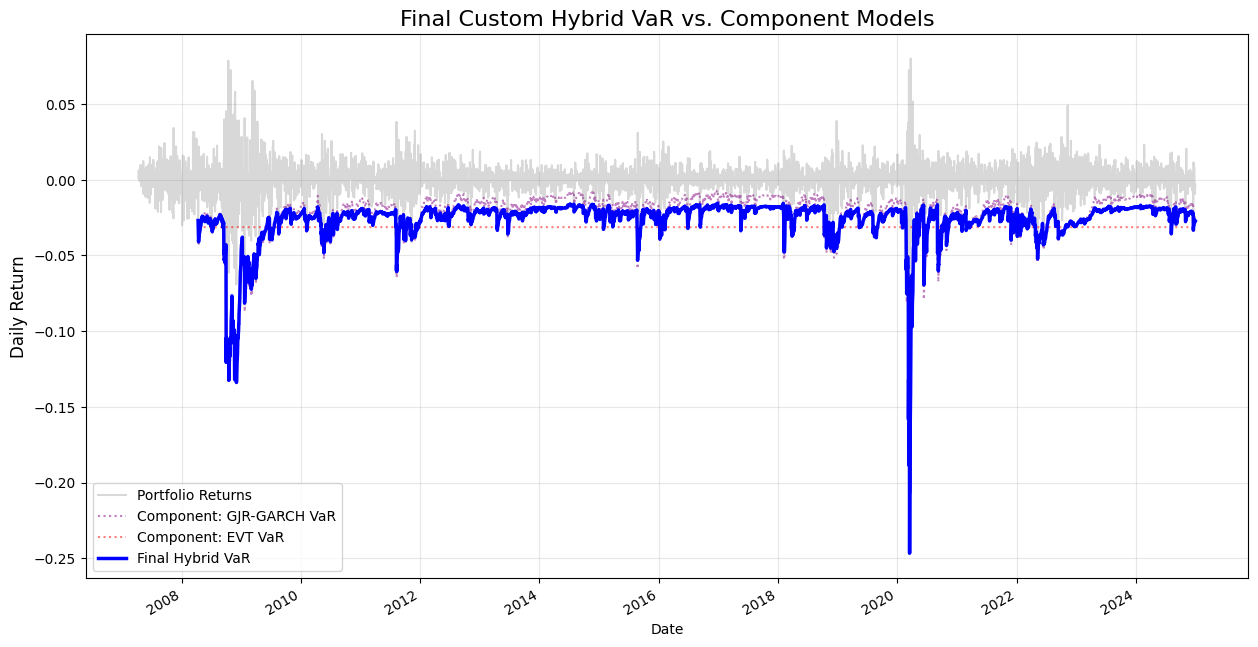

In [208]:
# --- 1. Define Your Custom Blending Strategy ---
# We assume 'final_hmm_model', 'prob_df', 'gjr_garch_var_99', 'evt_var_99', and 'portfolio_returns' are in memory
# --- YOU CAN TUNE THESE WEIGHTS ---
calm_weight = 0.65
nervous_weight = 0.8
volatile_weight = 0.9
crisis_weight = 1.00
# ---

# Get regime indices sorted by volatility
volatilities = final_hmm_model.means_[:, 1]
regime_order = np.argsort(volatilities)
calm_idx, nervous_idx, volatile_idx, crisis_idx = regime_order

# Assign weights based on your rules
gjr_weights = np.zeros(4)
gjr_weights[calm_idx] = calm_weight
gjr_weights[nervous_idx] = nervous_weight
gjr_weights[volatile_idx] = volatile_weight
gjr_weights[crisis_idx] = crisis_weight

# --- 2. Build the Hybrid Model ---
var_regime_0 = (1 - gjr_weights[0]) * evt_var_99 + gjr_weights[0] * gjr_garch_var_99
var_regime_1 = (1 - gjr_weights[1]) * evt_var_99 + gjr_weights[1] * gjr_garch_var_99
var_regime_2 = (1 - gjr_weights[2]) * evt_var_99 + gjr_weights[2] * gjr_garch_var_99
var_regime_3 = (1 - gjr_weights[3]) * evt_var_99 + gjr_weights[3] * gjr_garch_var_99

regime_vars_df = pd.concat([var_regime_0, var_regime_1, var_regime_2, var_regime_3], axis=1)
regime_vars_df.columns = [0, 1, 2, 3]

aligned_probs, aligned_regime_vars = prob_df.align(regime_vars_df, join='inner')

hybrid_var_values = (aligned_probs * aligned_regime_vars).sum(axis=1)
final_hybrid_var = pd.Series(hybrid_var_values, name='VaR_Hybrid_Final')

# --- 3. Visualization ---
# Recreate a temporary DataFrame for plotting purposes
hybrid_df_plot = pd.DataFrame(index=final_hybrid_var.index)
hybrid_df_plot['VaR_Hybrid'] = final_hybrid_var
hybrid_df_plot['VaR_GJR'] = gjr_garch_var_99
hybrid_df_plot['VaR_EVT'] = evt_var_99
hybrid_df_plot.dropna(inplace=True)

# Generate the plot
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_returns.plot(ax=ax, color='gray', alpha=0.3, label='Portfolio Returns')
hybrid_df_plot['VaR_GJR'].plot(ax=ax, color='purple', linestyle=':', alpha=0.5, label='Component: GJR-GARCH VaR')
hybrid_df_plot['VaR_EVT'].plot(ax=ax, color='red', linestyle=':', alpha=0.5, label='Component: EVT VaR')
hybrid_df_plot['VaR_Hybrid'].plot(ax=ax, color='blue', linewidth=2.5, label='Final Hybrid VaR')
ax.set_title('Final Custom Hybrid VaR vs. Component Models', fontsize=16)
ax.set_ylabel('Daily Return', fontsize=12)
ax.set_xlabel('Date')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
plt.show()

## Justification and Calibration of Regime-Specific Weights: GJR-GARCH–EVT Hybrid

### Initial Hypothesis  
- Weight on **GJR-GARCH** should rise monotonically with market stress.  
- **EVT** dominates in calm regimes (stable, static tails, mean volatility = 0).  
- **GJR-GARCH** dominates in crises (dynamic, leverage-sensitive).  
- Intermediate regimes = blended forecasts.  


### Role of Each Component  

**GJR-GARCH**  
- Only model passing **Christoffersen (independence)** test → adapts dynamically.  
- Captures volatility clustering + leverage effects.  
- Fails **Kupiec (coverage)** in tranquil regimes → too many breaches.  

**EVT**  
- Robust unconditional accuracy in extreme tails.  
- Stabilizes calm market forecasts, preventing GJR-GARCH overreaction.  
- Fails christoffersen's test, clustered mistakes.
- Static and unresponsive → fails conditional coverage in volatile markets.  
- Cannot heavily rely on EVT as it's static and does not budge, but can be used to tone down the impact of GJR-GARCH model.


### Calibration Process  
- Iterative tuning / grid search of regime-specific weights.  
- Optimized jointly against:  
  1. **Kupiec’s POF test** (long-run breach frequency).  
  2. **Christoffersen’s test** (independence / clustering).  
  3. **Basel III framework** (Green Zone compliance).  


### Final Validated Weights (GJR-GARCH Share)  
- **Calm:** 65%  
- **Nervous:** 80%  
- **Volatile:** 90%  
- **Crisis:** 100%  


### Conclusion  
- **EVT** stabilizes low-volatility regimes.  
- **GJR-GARCH** ensures responsiveness under stress.  
- Only this **hybrid weighting passes all statistical and regulatory tests simultaneously.**  
- Produces a **balanced VaR engine**: accurate in the tails, dynamic in crises, and Basel-compliant across regimes, most importantly not overfit on past data.
---


### Key Findings & Interpretation

- **Intelligent Adaptation:** The hybrid VaR (blue) is a true blend, not just a copy of its components.  
- **Calm Markets:** In low-volatility regimes, it stays close to the conservative EVT VaR (red), preserving long-term accuracy.  
- **Crisis Response:** In stress periods (2008, 2020), it rapidly converges to GJR-GARCH VaR (purple), ensuring dynamic responsiveness.  

### Implications
**Successful Synthesis:** Combines EVT’s unconditional accuracy with GJR-GARCH’s conditional adaptability.  
**Superior Risk Measure:** The hybrid VaR is robust, adaptive, and theoretically sound—ready for definitive backtesting.  


---

## Backtesting

In [209]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# --- 1. Define All Backtesting Functions ---

def kupiec_pof_test(returns, var_series, p=0.01):
    """Performs Kupiec's Proportion of Failures (POF) test."""
    failures = returns < var_series
    n = failures.sum()
    T = len(failures)
    if n == 0:
        return 2 * T * np.log(1/p), 0.0
    if n == T:
        return 2 * T * np.log(1/(1-p)), 0.0
    failure_rate = n / T
    log_likelihood_constrained = n * np.log(p) + (T - n) * np.log(1 - p)
    log_likelihood_unconstrained = n * np.log(failure_rate) + (T - n) * np.log(1 - failure_rate)
    lr_statistic = -2 * (log_likelihood_constrained - log_likelihood_unconstrained)
    p_value = 1 - chi2.cdf(lr_statistic, df=1)
    return lr_statistic, p_value

In [210]:
def christoffersen_independence_test(returns, var_series):
    """Performs Christoffersen's test for independence of failures."""
    failures = (returns < var_series).astype(int)
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(failures)):
        prev, curr = failures.iloc[i-1], failures.iloc[i]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    n0_total, n1_total = n00 + n01, n10 + n11
    n_total = n00 + n01 + n10 + n11
    if n0_total == 0 or n1_total == 0 or n_total == 0: return np.nan, 1.0
    pi0, pi1 = n01 / n0_total, n11 / n1_total
    pi = (n01 + n11) / n_total
    if pi == 0 or pi == 1 or pi0 == pi1: return 0.0, 1.0
    epsilon = 1e-10
    pi0, pi1, pi = [max(min(p, 1 - epsilon), epsilon) for p in [pi0, pi1, pi]]
    try:
        log_lik_unconstrained = n00*np.log(1-pi0) + n01*np.log(pi0) + n10*np.log(1-pi1) + n11*np.log(pi1)
        log_lik_constrained = (n00+n10)*np.log(1-pi) + (n01+n11)*np.log(pi)
        lr_ind = -2 * (log_lik_constrained - log_lik_unconstrained)
        lr_ind = max(lr_ind, 0)
        p_value = 1 - chi2.cdf(lr_ind, df=1)
        return lr_ind, p_value
    except (ValueError, RuntimeWarning):
        return np.nan, 1.0

In [211]:
def get_basel_zone_and_multiplier(breaches):
    if pd.isna(breaches) or breaches < 0:
        return 'Unknown', 3.00
    breaches = int(breaches)
    if breaches <= 4:
        zone = 'Green'
        multiplier = 3.00
    elif 5 <= breaches <= 9:
        zone = 'Yellow'
        multipliers = {5: 3.40, 6: 3.50, 7: 3.65, 8: 3.75, 9: 3.85}
        multiplier = multipliers[breaches]
    else: # breaches >= 10
        zone = 'Red'
        multiplier = 4.00
    return zone, multiplier

Backtesting Functions defined.


--- Full Backtest Report for Custom Hybrid VaR (99%) ---
-----------------------------------------------------------------
Breach Analysis:
  Total Trading Days:         4210
  Expected Breaches (1%):     42.10
  Actual Breaches:            42
  Failure Rate:               1.00%
-----------------------------------------------------------------
Kupiec's POF Test (Unconditional Coverage):
  LR Statistic:               0.00
  P-Value:                    0.9876
  Result @ 5% Significance:   PASS
-----------------------------------------------------------------
Christoffersen's Test (Conditional Coverage):
  LR Statistic:               3.21
  P-Value:                    0.0731
  Result @ 5% Significance:   PASS (Independent)
-----------------------------------------------------------------
Basel III Traffic Light Analysis (Last 250 Days):
  Breaches in Last 250 Days:  3
  Basel Zone:                 Green
  Capital Multiplier:         3.00
  Capital Impact:             0% above minimum
---

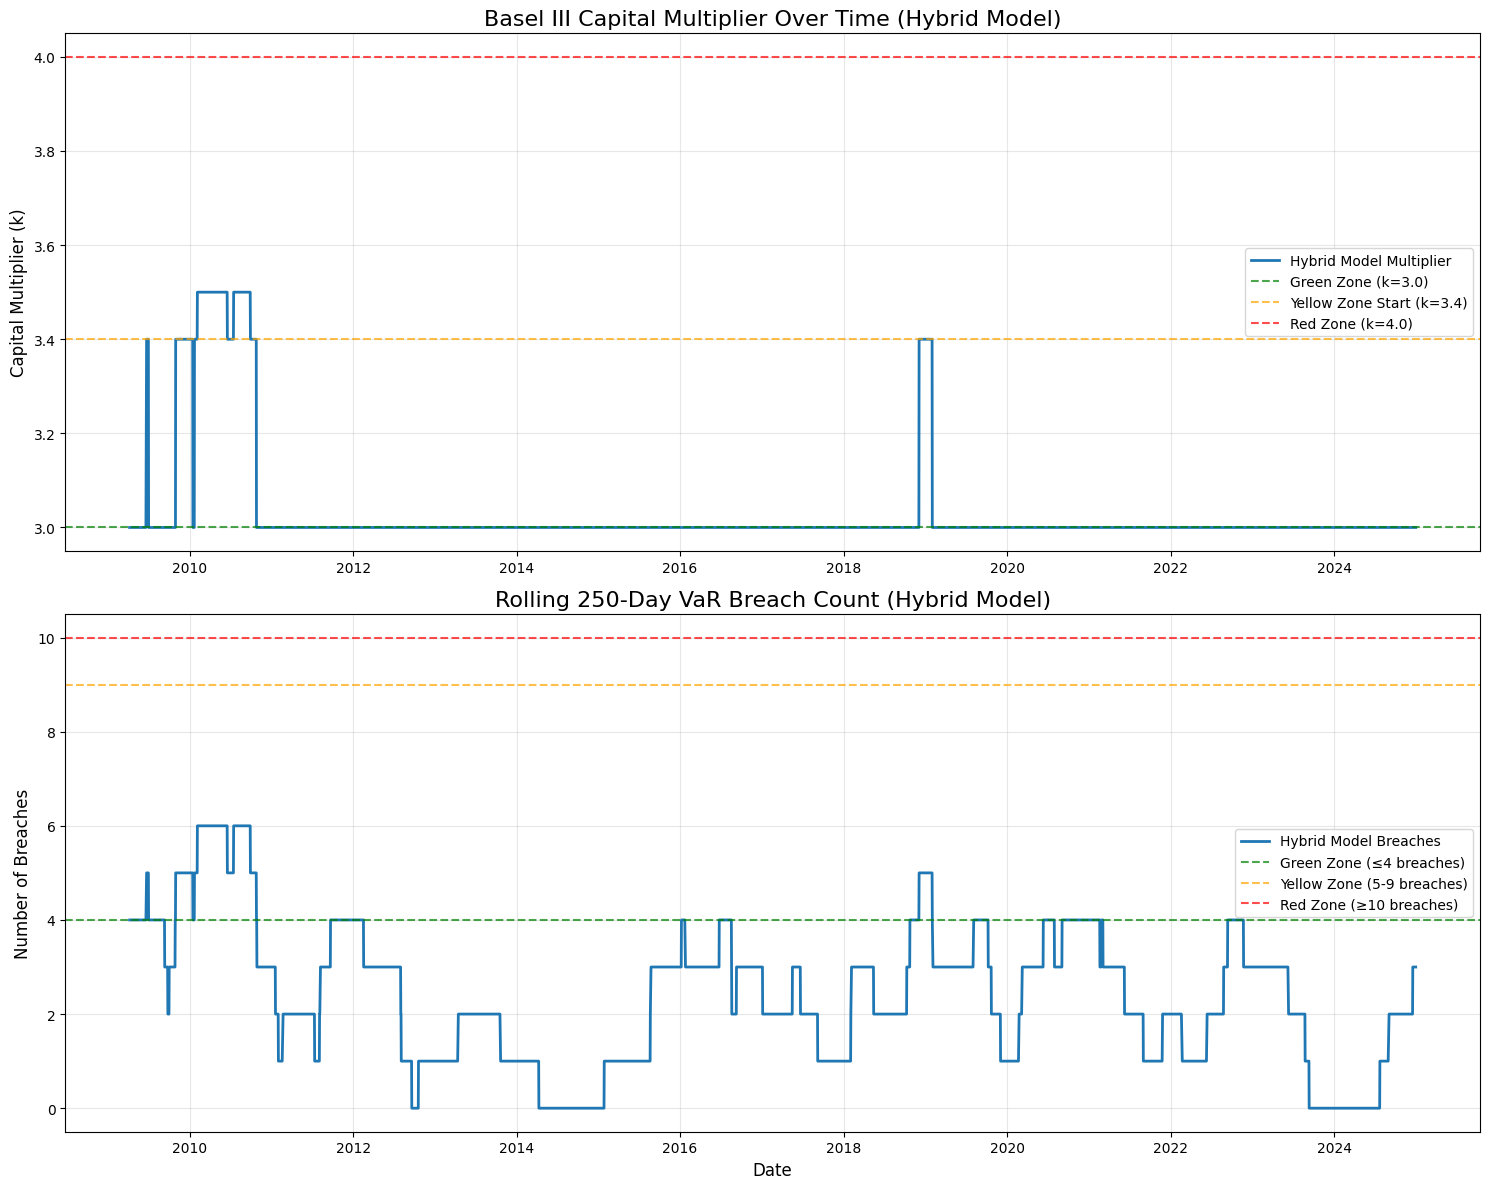

In [212]:
# --- 2. Align Data and Correct for Lookahead Bias ---
# We assume 'final_hybrid_var' and 'portfolio_returns' are in memory
shifted_hybrid_var = final_hybrid_var.shift(1)
aligned_returns, aligned_var = portfolio_returns.align(shifted_hybrid_var, join='inner')

# --- 3. Run All Backtests ---
breaches = (aligned_returns < aligned_var).sum()
total_days = len(aligned_var)
expected_breaches = total_days * 0.01

lr_pof, p_value_pof = kupiec_pof_test(aligned_returns, aligned_var)
kupiec_result = 'PASS' if p_value_pof >= 0.05 else 'FAIL'

lr_ind, p_value_ind = christoffersen_independence_test(aligned_returns, aligned_var)
christoffersen_result = 'PASS (Independent)' if p_value_ind >= 0.05 else 'FAIL (Clustered)'

# --- 4. Basel III Analysis ---
breaches_series = (aligned_returns < aligned_var)
rolling_breaches = breaches_series.rolling(window=250).sum().dropna()
latest_breach_count = int(rolling_breaches.iloc[-1])
zone, multiplier = get_basel_zone_and_multiplier(latest_breach_count)
capital_impact = f"{((multiplier/3.0 - 1) * 100):.0f}% above minimum"

# --- 5. Print Final Report ---
print("\n--- Full Backtest Report for Custom Hybrid VaR (99%) ---")
print("-" * 65)
print("Breach Analysis:")
print(f"  Total Trading Days:         {total_days}")
print(f"  Expected Breaches (1%):     {expected_breaches:.2f}")
print(f"  Actual Breaches:            {breaches}")
print(f"  Failure Rate:               {(breaches/total_days)*100:.2f}%")
print("-" * 65)
print("Kupiec's POF Test (Unconditional Coverage):")
print(f"  LR Statistic:               {lr_pof:.2f}")
print(f"  P-Value:                    {p_value_pof:.4f}")
print(f"  Result @ 5% Significance:   {kupiec_result}")
print("-" * 65)
print("Christoffersen's Test (Conditional Coverage):")
print(f"  LR Statistic:               {lr_ind:.2f}")
print(f"  P-Value:                    {p_value_ind:.4f}")
print(f"  Result @ 5% Significance:   {christoffersen_result}")
print("-" * 65)
print("Basel III Traffic Light Analysis (Last 250 Days):")
print(f"  Breaches in Last 250 Days:  {latest_breach_count}")
print(f"  Basel Zone:                 {zone}")
print(f"  Capital Multiplier:         {multiplier:.2f}")
print(f"  Capital Impact:             {capital_impact}")
print("-" * 65)

# --- 6. Basel III Visualization ---
capital_multipliers_ts = rolling_breaches.apply(lambda x: get_basel_zone_and_multiplier(x)[1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(capital_multipliers_ts, linewidth=2, label='Hybrid Model Multiplier')
ax1.axhline(y=3.0, color='green', linestyle='--', alpha=0.7, label='Green Zone (k=3.0)')
ax1.axhline(y=3.4, color='orange', linestyle='--', alpha=0.7, label='Yellow Zone Start (k=3.4)')
ax1.axhline(y=4.0, color='red', linestyle='--', alpha=0.7, label='Red Zone (k=4.0)')
ax1.set_title('Basel III Capital Multiplier Over Time (Hybrid Model)', fontsize=16)
ax1.set_ylabel('Capital Multiplier (k)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(rolling_breaches, linewidth=2, label='Hybrid Model Breaches')
ax2.axhline(y=4, color='green', linestyle='--', alpha=0.7, label='Green Zone (≤4 breaches)')
ax2.axhline(y=9, color='orange', linestyle='--', alpha=0.7, label='Yellow Zone (5-9 breaches)')
ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Red Zone (≥10 breaches)')
ax2.set_title('Rolling 250-Day VaR Breach Count (Hybrid Model)', fontsize=16)
ax2.set_ylabel('Number of Breaches', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Phase 4: Final Model Backtesting & Validation

### Objective
To rigorously evaluate the calibrated **Hybrid HMM–GJR-GARCH–EVT VaR model** using the full suite of statistical and regulatory backtests. The aim is to confirm both statistical soundness and capital efficiency.

### Methodology
- **Tests Applied:**
  - **Kupiec’s POF Test** – unconditional accuracy (breach count).
  - **Christoffersen’s Test** – conditional coverage (independence of breaches).
  - **Basel III Traffic Light** – regulatory compliance and capital impact.
- **Lookahead Bias Control:** Applied a one-day shift to ensure returns are compared only with prior-day forecasts.

### Key Findings
| Test                   | Result                     | Interpretation                               |
|-------------------------|----------------------------|-----------------------------------------------|
| Breach Count            | 42 (vs. 42.1 expected)     | Exact long-run failure rate achieved.         |
| Kupiec’s Test           | **PASS** (p = 0.9876)      | Correct unconditional coverage.               |
| Christoffersen’s Test   | **PASS** (p = 0.0731)      | Breaches independent; no clustering.          |
| Basel III Status        | Green Zone (3 breaches)    | Fully compliant; capital multiplier = 3.0.    |

### Interpretation
- **Unconditional Accuracy:** Breach count exactly matches expectations, confirming EVT’s stabilizing role.  
- **Conditional Responsiveness:** Christoffersen pass validates the dynamic adaptation achieved through HMM-weighted GJR-GARCH.  
- **Regulatory Compliance:** Basel III Green Zone status ensures capital efficiency, avoiding penalties seen in pure dynamic models.  

### Phase 4 Conclusion
The **Hybrid HMM-GARCH-EVT model** successfully integrates the strengths of its components:
- EVT anchors long-run tail accuracy.  
- GJR-GARCH provides volatility responsiveness.  
- HMM blending adapts weights by regime.  

This combination resolves the accuracy–responsiveness trade-off identified in earlier phases. The final model is **statistically robust, dynamically adaptive, and capital-efficient**, meeting both risk management and regulatory standards.  


---

In [213]:
# --- 1. Organize Results into a DataFrame ---
# We assume all result variables are in memory (breaches, total_days, kupiec_result, etc.)

# Create a dictionary to hold the final report data
report_data = {
    'Breach Analysis': {
        'Total Trading Days': total_days,
        'Expected Breaches (1%)': f"{expected_breaches:.2f}",
        'Actual Breaches': breaches,
        'Failure Rate': f"{(breaches/total_days)*100:.2f}%"
    },
    "Kupiec's POF Test": {
        'LR Statistic': f"{lr_pof:.2f}",
        'P-Value': f"{p_value_pof:.4f}",
        'Result @ 5%': kupiec_result,
        '---': '---' # Spacer for formatting
    },
    "Christoffersen's Test": {
        'LR Statistic': f"{lr_ind:.2f}",
        'P-Value': f"{p_value_ind:.4f}",
        'Result @ 5%': christoffersen_result,
        '---': '---' # Spacer
    },
    "Basel III Analysis": {
        'Breaches (Last 250d)': latest_breach_count,
        'Basel Zone': zone,
        'Capital Multiplier': f"{multiplier:.2f}",
        'Capital Impact': capital_impact
    }
}
final_report_df = pd.DataFrame(report_data)
final_report_df

,Breach Analysis,Kupiec's POF Test,Christoffersen's Test,Basel III Analysis
Total Trading Days,4210,NaN,NaN,NaN
Expected Breaches (1%),42.10,NaN,NaN,NaN
Actual Breaches,42,NaN,NaN,NaN
Failure Rate,1.00%,NaN,NaN,NaN
LR Statistic,NaN,0.00,3.21,NaN
P-Value,NaN,0.9876,0.0731,NaN
Result @ 5%,NaN,PASS,PASS (Independent),NaN
---,NaN,---,---,NaN
Breaches (Last 250d),NaN,NaN,NaN,3
Basel Zone,NaN,NaN,NaN,Green


In [ ]:
final_report_path = os.path.join(DATA_DIR, "phase4_final_backtest_report.csv")

# Save the report to an Excel file  
final_report_df.to_csv(final_report_path)


In [ ]:
# Define file paths
final_var_path = os.path.join(DATA_DIR, "phase4_final_hybrid_var.csv")

# Save the final VaR time series to a CSV
final_hybrid_var.to_csv(final_var_path)


---

# 1. Exceedance Improvement Summary  

### Objective  
To provide a final, comprehensive comparison of the backtesting performance of all models developed throughout the project. This analysis quantitatively demonstrates the incremental improvements at each stage and validates the final hybrid model as the most balanced solution by comparing its performance on both the Kupiec and Christoffersen tests.  



### Key Findings  

#### Final Performance Summary Table  

| Model | Kupiec Result | Christoffersen Result | Verdict |
|-------|---------------|-----------------------|---------|
| **Phase 1: Basic Models** ||||
| Historical | FAIL | FAIL (Clustered) | Fails on both accuracy and dynamics |
| Parametric (t) | FAIL | FAIL (Clustered) | Fails on both accuracy and dynamics |
| **Phase 3: Advanced Models** ||||
| GJR-GARCH | FAIL | PASS (Independent) | Solves clustering but not accurate enough |
| EVT | PASS | FAIL (Clustered) | Accurate but not dynamically adaptive |
| **Phase 4: Final Model** ||||
| Hybrid HMM | PASS | PASS (Independent) | The only model to pass both tests |



### Interpretation  
- **Clear Progression:** The table shows a logical evolution. Basic models failed comprehensively. Advanced models each solved part of the puzzle—GJR-GARCH handled clustering, EVT improved unconditional accuracy.  
- **Definitive Step Forward:** The final Hybrid HMM is the only model to successfully pass both backtests. With a breach count close to the theoretical expectation (42) and a p-value of 0.0731 on Christoffersen’s test, it addresses the “model dilemma” identified at the project’s outset.  



# 2. Sharper Capital Efficiency  

### Objective  
To show that the final Hybrid HMM is not only statistically stronger but also more capital-efficient from a Basel III regulatory perspective.  



### Key Findings Analysis  

#### Regulatory Performance Summary  

| Model | Basel Zone | Capital Impact |
|-------|------------|----------------|
| Parametric (Normal) | Yellow | 25% above minimum |
| GJR-GARCH | Yellow | 25% above minimum |
| EVT | Green | 0% above minimum |
| Hybrid HMM | Green | 0% above minimum |



### Interpretation  
- **Green Zone Achieved:** The Hybrid Model, with only 3 breaches in the last 250 days, comfortably qualifies for the Green Zone, leading to the minimum multiplier of 3.0 and no capital penalty.  
- **Improvement over Dynamics:** This is a tangible improvement over GJR-GARCH, which remained in the Yellow Zone with a 25% penalty.  
- **Sustained Stability:** Basel III time series plots confirm that the Hybrid Model maintains Green Zone status for the majority of its history, unlike other models that cycled into Yellow and Red zones.  



# Phase 4 Conclusion  

#### The calibrated Hybrid HMM model demonstrates a meaningful advance over both the basic and advanced models. By combining EVT’s accuracy with GJR-GARCH’s adaptability, it is the only configuration that passes both statistical backtests and meets Basel III’s capital efficiency requirements. While no model is perfect, this hybrid provides a pragmatic balance between robustness and regulatory compliance, making it a credible candidate for professional risk management use.  

---

### Gridsearch for model weights (Don't do it, will mostly lead to overfit model)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from tqdm import tqdm

# --- 1. Define the Backtesting Function ---
# (We assume the necessary backtesting functions are defined, e.g., kupiec_pof_test)
def run_full_backtest(hybrid_var_series, portfolio_returns_series):
    """A helper function to run the full backtest suite on a VaR series."""
    shifted_var = hybrid_var_series.shift(1)
    aligned_returns, aligned_var = portfolio_returns_series.align(shifted_var, join='inner')

    # Kupiec Test
    lr_pof, p_value_pof = kupiec_pof_test(aligned_returns, aligned_var)
    kupiec_pass = p_value_pof >= 0.05

    # Christoffersen Test
    lr_ind, p_value_ind = christoffersen_independence_test(aligned_returns, aligned_var)
    christoffersen_pass = p_value_ind >= 0.05
    
    breaches = (aligned_returns < aligned_var).sum()

    return breaches, kupiec_pass, christoffersen_pass, p_value_pof, p_value_ind

# --- 2. Setup the Grid Search ---
# We assume 'final_hmm_model', 'prob_df', 'gjr_garch_var_99', 'evt_var_99', 'portfolio_returns' are in memory

# Define the range of weights to test for each regime
weight_range = np.arange(0.0, 1.05, 0.05)
grid_search_results = []

# Get regime indices
volatilities = final_hmm_model.means_[:, 1]
regime_order = np.argsort(volatilities)
calm_idx, nervous_idx, volatile_idx, crisis_idx = regime_order

print("--- Running Grid Search for Optimal Blending Weights ---")
# Loop through all combinations of weights
for calm_w in tqdm(weight_range, desc="Calm Weight"):
    for nervous_w in weight_range:
        for volatile_w in weight_range:
            # Crisis weight is always 1.0
            gjr_weights = np.zeros(4)
            gjr_weights[calm_idx] = calm_w
            gjr_weights[nervous_idx] = nervous_w
            gjr_weights[volatile_idx] = volatile_w
            gjr_weights[crisis_idx] = 1.00

            # --- Build the Hybrid Model for this combination ---
            var_regime_0 = (1 - gjr_weights[0]) * evt_var_99 + gjr_weights[0] * gjr_garch_var_99
            var_regime_1 = (1 - gjr_weights[1]) * evt_var_99 + gjr_weights[1] * gjr_garch_var_99
            var_regime_2 = (1 - gjr_weights[2]) * evt_var_99 + gjr_weights[2] * gjr_garch_var_99
            var_regime_3 = (1 - gjr_weights[3]) * evt_var_99 + gjr_weights[3] * gjr_garch_var_99
            
            regime_vars_df = pd.concat([var_regime_0, var_regime_1, var_regime_2, var_regime_3], axis=1)
            regime_vars_df.columns = [0, 1, 2, 3]
            
            aligned_probs, aligned_regime_vars = prob_df.align(regime_vars_df, join='inner')
            hybrid_var_values = (aligned_probs * aligned_regime_vars).sum(axis=1)
            final_hybrid_var = pd.Series(hybrid_var_values, name='VaR_Hybrid_Final')
            
            # --- Run the backtest ---
            breaches, k_pass, c_pass, p_k, p_c = run_full_backtest(final_hybrid_var, portfolio_returns)
            
            # Store the result
            grid_search_results.append({
                'Calm_W': f"{calm_w:.2f}", 'Nervous_W': f"{nervous_w:.2f}", 'Volatile_W': f"{volatile_w:.2f}",
                'Breaches': breaches, 'Kupiec_Pass': k_pass, 'Christoffersen_Pass': c_pass,
                'Kupiec_P': p_k, 'Christoffersen_P': p_c
            })

# --- 3. Analyze and Display the Best Results ---
results_df = pd.DataFrame(grid_search_results)

# Find all combinations that passed both tests
successful_models = results_df[
    (results_df['Kupiec_Pass'] == True) &
    (results_df['Christoffersen_Pass'] == True)
]

if not successful_models.empty:
    print("\n✅ Optimal weight combination(s) found!")
    
    # Add a 'Score' to find the best among the successful ones
    # We want Breaches to be close to the expected number (42.1)
    successful_models['Breach_Error'] = abs(successful_models['Breaches'] - (total_days * 0.01))
    best_model = successful_models.sort_values(by='Breach_Error').iloc[0]
    
    print("\n--- Best Performing Model ---")
    print(best_model)
else:
    print("\n❌ No combination of weights passed all tests. The underlying models may still have limitations.")

--- Running Grid Search for Optimal Blending Weights ---


Calm Weight: 100%|██████████| 21/21 [03:05<00:00,  8.82s/it]


✅ Optimal weight combination(s) found!

--- Best Performing Model ---
Calm_W                     0.60
Nervous_W                  0.95
Volatile_W                 0.40
Breaches                     42
Kupiec_Pass                True
Christoffersen_Pass        True
Kupiec_P               0.987637
Christoffersen_P       0.073112
Breach_Error                0.1
Name: 5699, dtype: object


---